### Main imports and GPU settings

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import matplotlib.pyplot as plt


# Show all available GPUs
print(torch.cuda.get_device_name(0))

# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print('=======================\n')
# Set default tensor type to cuda.FloatTensor if GPU is available
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    torch.set_default_device(device)
    torch.set_default_dtype(torch.float)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Dtype: {torch.get_default_dtype()}")
    print(f"Device: {torch.cuda.current_device()}")
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    print("Using CPU")


# Set seed for reproducibility
torch.manual_seed(0)

NVIDIA GeForce RTX 2060
cuda:0

Using GPU: NVIDIA GeForce RTX 2060
Dtype: torch.float32
Device: 0


### Local imports of classes

In [102]:
import random
import importlib

# Local imports modules
import classes.SimulationNN as SimulationNN
import classes.Systems as Systems
import classes.PID as PID

# Reload modules
importlib.reload(SimulationNN)
importlib.reload(Systems)
importlib.reload(PID)

# Local import reloaded classes
from classes.SimulationNN import SimulationNN
from classes.Systems import Trolley
from classes.PID import PID

### Build Neural Network and CustomLoss function

In [103]:
# Defining the architecture of the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 6)
        self.fc2 = nn.Linear(6, 3)
        self.act_tahn = nn.Tanh()
        self.act_sigmoid = nn.Sigmoid()

        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x) -> Tensor:
        x = self.fc1(x)
        x = self.act_tahn(x)
        x = self.fc2(x)
        # x = self.act_sigmoid(x)
        return x


# Custom Loss Function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, vector_K: Tensor, vector_E: Tensor, dt: Tensor):
        """
        Args:
            vector_K (tensor): [Kp_t, Kp_t_1, Ki_t, Ki_t_1, Kd_t, Kd_t_1] vector of the gains
            vector_E (tensor): [E_t, E_t_1] vector of the errors
            dt (float): time step between the current and previous position

        Returns:
            loss (tensor): loss function
        """
        # Unpack the vectors
        Kp_t, Kp_t_1, Ki_t, Ki_t_1, Kd_t, Kd_t_1 = vector_K
        E_t, E_t_1 = vector_E

        # Compute the derivative of the error with gains
        dEdKp = (E_t - E_t_1) / (Kp_t - Kp_t_1)
        dEdKi = (E_t - E_t_1) / (Ki_t - Ki_t_1)
        dEdKd = (E_t - E_t_1) / (Kd_t - Kd_t_1)

        # Compute the loss function
        loss_Kp = torch.mean(dEdKp**2)
        loss_Ki = torch.mean(dEdKi**2)
        loss_Kd = torch.mean(dEdKd**2)

        # Compute the total loss
        loss = loss_Kp + loss_Ki + loss_Kd        

        # mse_loss = torch.mean(error**2).to(device)
        # control_loss = torch.mean((u_t_1-u_t)**2).to(device)
        # loss = mse_loss + control_loss


        # loss = torch.mean((dxdt)**2)
        return loss


### Creating the model, loss function and optimizer

In [104]:
# Model
model = NeuralNetwork()

# Loss function
custom_loss = CustomLoss()

# Optimizers
optimizer = optim.SGD(model.parameters(), lr=0.005)


In [105]:

DT = torch.tensor(0.02)
TIME = torch.arange(0, 120, DT)
TARGET = 5 * torch.zeros(len(TIME))
DISTURBANCE = torch.zeros(len(TIME))

mass = torch.tensor(1)
friction = torch.tensor(0.1)
trolley = Trolley(mass=mass, friction=friction, dt=DT)

KP = torch.tensor(0.1)
KI = torch.tensor(0.1)
KD = torch.tensor(0.1)
pid = PID(KP, KI, KD)
pid.setLims(None, None)

simulation = SimulationNN(TIME, TARGET, DISTURBANCE, DT)
simulation.model = model
simulation.custom_loss = custom_loss
simulation.optimizer = optimizer

In [106]:
EPOCHS = 10
for i in range(EPOCHS):
    # Reset the trolley and simulation
    trolley.reset()
    simulation.reset()    

    print(f"-----------------Epoch {i+1}/{EPOCHS}-----------------")

    TARGET = torch.ones(len(TIME)) * random.uniform(0, 10)
    TARGET[TIME > 30] = random.uniform(0, 10)
    TARGET[TIME > 60] = random.uniform(0, 10)
    TARGET[TIME > 90] = random.uniform(0, 10)
    # TARGET[TIME > 160] = random.uniform(0, 10)

    trolley.mass = torch.tensor(random.uniform(0.5, 3))
    trolley.friction = torch.tensor(random.uniform(0.01, 0.5))
    trolley.spring_constant = torch.tensor(random.uniform(0, 100))

    simulation.target = TARGET
    simulation.run(trolley, pid)        

-----------------Epoch 1/10-----------------


Loss: nan | Error: nan, X_targ: 5.0129 | U: nan | Kp: nan, Ki: nan, Kd: nan: 100%|██████████| 6000/6000 [00:57<00:00, 105.02it/s]   


-----------------Epoch 2/10-----------------


Loss: nan | Error: nan, X_targ: 7.0574 | U: nan | Kp: nan, Ki: nan, Kd: nan:  73%|███████▎  | 4407/6000 [01:01<00:22, 71.75it/s] 


KeyboardInterrupt: 

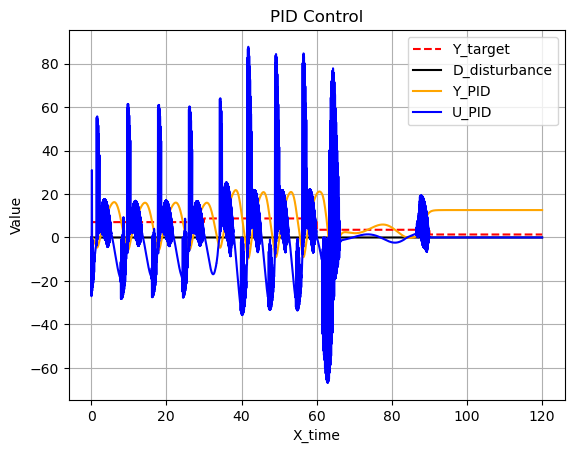

tensor([0.0000e+00, 2.0000e-02, 4.0000e-02,  ..., 1.1996e+02, 1.1998e+02,
        1.2000e+02])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0.0000, 0.7730, 1.7234,  ..., 0.0000, 0.0000, 0.0000])
tensor([0., 0., 0.,  ..., 0., 0., 0.])


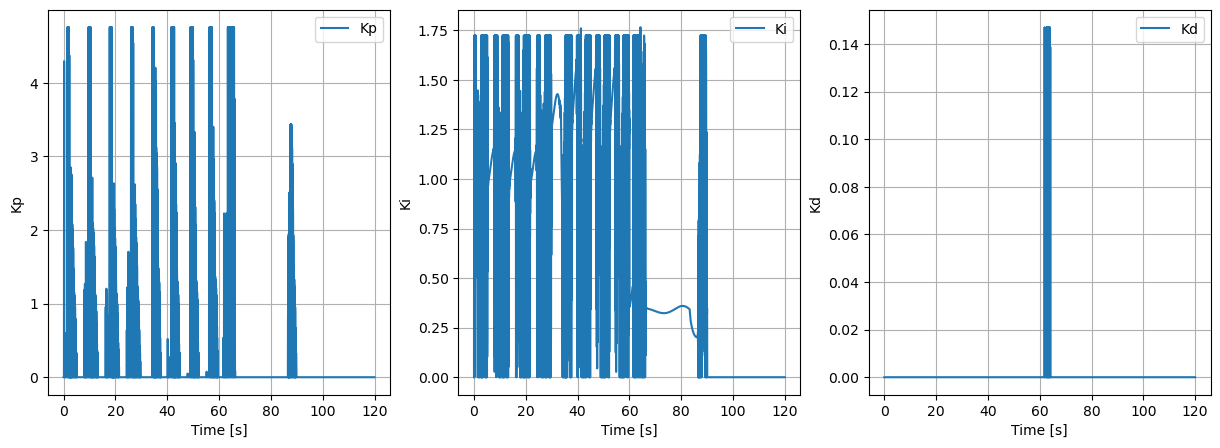

In [ ]:
simulation.plot()
simulation.plot_K()

In [ ]:
# Save the model
torch.save(model.state_dict(), 'model.pth')
print("Model saved successfully")

Model saved successfully
